In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torch.utils.data as data
from torch.optim import SGD
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import random
import torch.utils.data as torchdata
from torch.utils.data import SubsetRandomSampler
import matplotlib.pyplot as plt
import time
# from train_model import train_model
# from test_model import test_model
%matplotlib inline
import pickle

In [2]:
import tent

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
# filePath = '/local/rcs/ll3504/datasets/256_ObjectCategories/'
# namelist = os.listdir(filePath)
# nameDic_cal = {}
# for name in namelist:
#     splits = name.split(".")
#     nameDic_cal[int(splits[0])-1] = splits[1]
# print(nameDic_cal[1])

In [5]:
def get_dataset(path='/database', dataset_name='caltech-256-common'):
    # No holdout testing data. train and test data are the same, but different transformation
    data_transforms = {
        'train': transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    }

    tr_dataset = datasets.ImageFolder(path + dataset_name + '/', data_transforms['train'])
    te_dataset = datasets.ImageFolder(path + dataset_name + '/', data_transforms['test'])

    return tr_dataset, te_dataset

In [6]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [7]:
def split_dataset(train_dataset, test_dataset, valid_size=0.02, batch_size=128, train_size = 128, seed_worker = seed_worker):
    '''
    This function splits dataset into train, val, and test sets, and return train, val, test dataloaders.
    Val and Test loaders are the same

    '''
    # what does the len function gives?
    random.seed(0)
    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    random.shuffle(indices)
    train_idx, valid_idx = indices[split:split+train_size], indices[:split]
#     print("DEBUGGInG train_idx: ", train_idx)
#     print("DEBUGGInG valid_idx: ", valid_idx)
    
#     torch.manual_seed(0)

    g = torch.Generator()
    g.manual_seed(0)
    
    train_sampler = SubsetRandomSampler(train_idx, g)
    valid_sampler = SubsetRandomSampler(valid_idx, g)
    


    train_loader = torchdata.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=48, worker_init_fn=seed_worker, pin_memory=True, drop_last=False, sampler = train_sampler)
    test_loader = torchdata.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=48, worker_init_fn=seed_worker, pin_memory=True, drop_last=False, sampler = valid_sampler)
    dataloaders = {'train': train_loader,
                   'val': test_loader,
                   'test': test_loader}
    dataset_sizes ={'train': train_size, #int(np.floor((1-valid_size) * num_train)),
                    'val': int(np.floor(valid_size * num_train)),
                    'test': int(np.floor(valid_size * num_train))}
    return dataloaders, dataset_sizes

In [214]:
snowtrain, snowtest = get_dataset(imagebase, 'imagenetc/' + 'snow' + '/' + str(1))

In [182]:
random.seed(0)
torch.manual_seed(0)

indices = list(range(len(snowtrain)))
random.shuffle(indices)
print(indices[:10])
torch.randperm(len(indices))
indices[torch.randperm(len(indices))[457]]

[6690, 6328, 33879, 1537, 24917, 38051, 10371, 42812, 116, 7393]


31203

In [8]:
imagebase = '/local/rcs/ll3504/datasets/'

In [9]:
imnc_corruption = ['gaussian_noise', 'shot_noise', 'impulse_noise', \
                   'defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur', \
                   'snow', 'frost', 'fog',\
                   'brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression']
corruption = ['fog', 'snow', 'spatter', 'gaussian_blur', 'gaussian_noise', 'brightness']
weather = ['fog', 'snow', 'spatter', 'frost']
digital = ['gaussian_noise', 'gaussian_blur', 'brightness', 'defocus_blur', 'contrast'] # NO gaussian noise in the files


In [10]:
def get_imagenetc(imagebase, batch_size=128, sample_size = 128, corruption=corruption):
    '''
    Returns:
        ref_dataloaders:          ImageNet original validation data, as a reference
        ref_dataset_sizes:        1000, not the sizes of the real dataset in the ref_loader, probs used downstream
        corrupted_dataloaders:    A list of corrupted dataloaders, each element in a list represetns the data loaders
                                  for one corruption type. Each element contains ['train']['val']['test'] loaders
        corrupted_dataset_sizes:  A list of dictionaries of the sizes of each loaders for each corruption
        corruption:               A list of corruption names, in the same order of the corrupted_dataloaders
    '''
    corrupted_dataloaders = {}
    
    imagenet_val = datasets.ImageNet(imagebase+'imagenetc/', split='val', transform=transforms.Compose([
            transforms.Resize([224, 224]),
            transforms.CenterCrop((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
                                   target_transform=None)#, download=False)
    
    random_indices = random.sample(range(0, len(imagenet_val)), int(len(imagenet_val)*0.02))
    imagenet_val_subset = data.Subset(imagenet_val, random_indices)
    clean_val_loader = torch.utils.data.DataLoader(imagenet_val_subset,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=48)
    corrupted_dataloaders['clean'] = clean_val_loader
#     ref_dataloaders = { 'val': val_loader,
#                        'test': val_loader}
#     ref_dataset_sizes ={'val': int(len(val_loader.dataset)),
#                         'test': int(len(val_loader.dataset))}
    
    # for every type of corruption, go to the specified severity folder
    for corr in corruption:
        dataloader_all_sev = []

        for severity in range(1,6):
            
            dataset_name = 'imagenetc/' + corr + '/' + str(severity)
            # Get dataset from folder
            corr_trian_images, corr_test_images = get_dataset(imagebase, dataset_name)

            # Get corruption-specific train, val, test loader
                # train: training data, non-overlap with val/test
                # val: non-overlap with train, same as test
                # test: non-overlap with train, same as test

            corr_dataloaders, _ = split_dataset(corr_trian_images, corr_test_images, valid_size=0.02, batch_size=batch_size, train_size=sample_size)

            dataloader_all_sev.append(corr_dataloaders)
            corrupted_dataloaders[corr] = dataloader_all_sev
        
        
#     return ref_dataloaders, ref_dataset_sizes, corrupted_dataloaders, corrupted_dataset_sizes, corruption
    return clean_val_loader, corrupted_dataloaders




In [11]:
clean_loader, imc_loaders = get_imagenetc(imagebase, batch_size=64, sample_size = 512, corruption=imnc_corruption)
clean_loader, imc_loaders

(<torch.utils.data.dataloader.DataLoader at 0x7fe07c8b5fa0>,
 {'clean': <torch.utils.data.dataloader.DataLoader at 0x7fe07c8b5fa0>,
  'gaussian_noise': [{'train': <torch.utils.data.dataloader.DataLoader at 0x7fe07490cbe0>,
    'val': <torch.utils.data.dataloader.DataLoader at 0x7fe07490cc70>,
    'test': <torch.utils.data.dataloader.DataLoader at 0x7fe07490cc70>},
   {'train': <torch.utils.data.dataloader.DataLoader at 0x7fe07490cf40>,
    'val': <torch.utils.data.dataloader.DataLoader at 0x7fe07490cfd0>,
    'test': <torch.utils.data.dataloader.DataLoader at 0x7fe07490cfd0>},
   {'train': <torch.utils.data.dataloader.DataLoader at 0x7fe0715452e0>,
    'val': <torch.utils.data.dataloader.DataLoader at 0x7fe071545370>,
    'test': <torch.utils.data.dataloader.DataLoader at 0x7fe071545370>},
   {'train': <torch.utils.data.dataloader.DataLoader at 0x7fe071545640>,
    'val': <torch.utils.data.dataloader.DataLoader at 0x7fe0715456d0>,
    'test': <torch.utils.data.dataloader.DataLoader at 

## Checking to see if the shuffled dataloader is deterministic

In [45]:
random.seed(1)
np.random.seed(1)

In [46]:
snow_loader = imc_loaders['snow'][0]['val']


In [47]:
len(snow_loader)

16

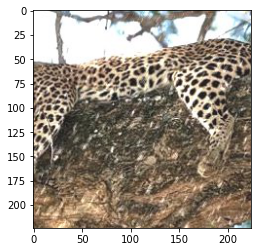

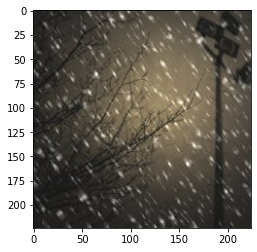

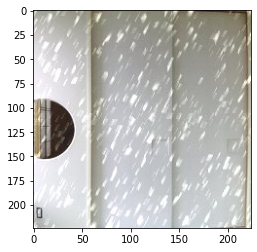

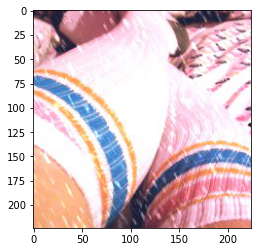

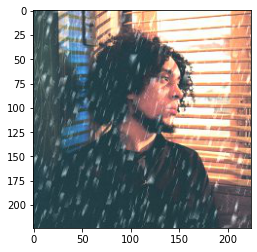

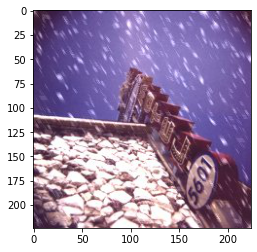

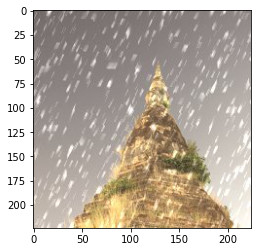

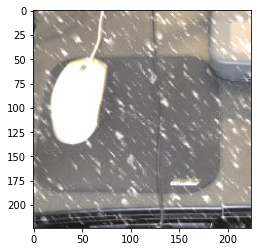

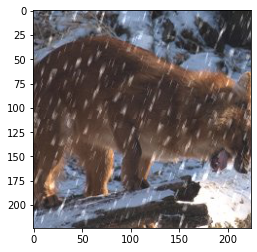

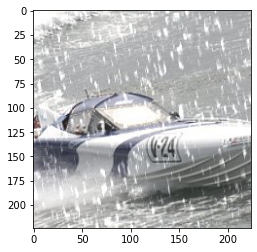

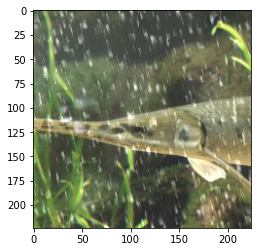

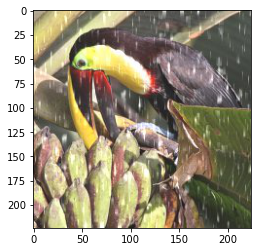

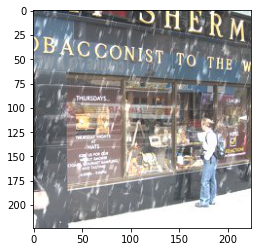

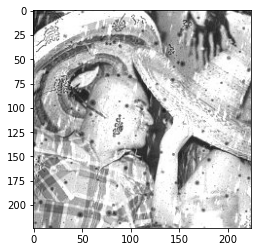

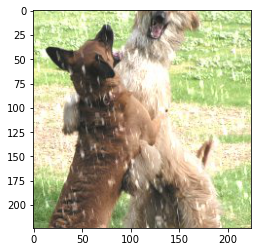

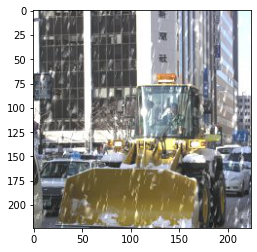

In [48]:
step=0
for images, targets in snow_loader:
    plt.imshow((images[0]).permute(1, 2, 0))
    plt.show()

In [49]:
fog_loader = imc_loaders['fog'][0]['val']

In [50]:
len(fog_loader)

16

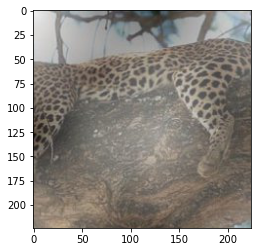

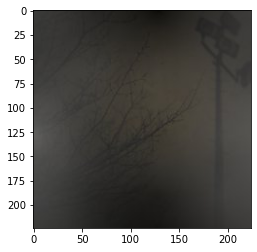

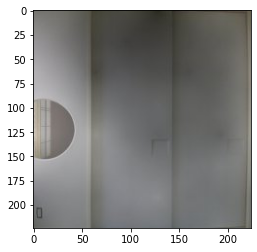

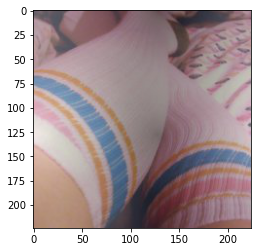

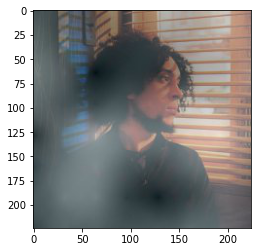

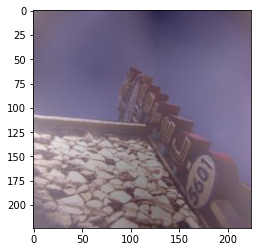

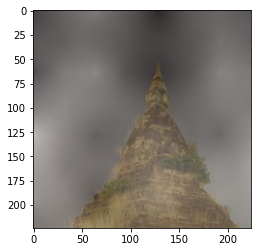

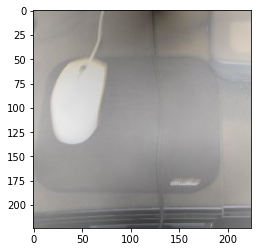

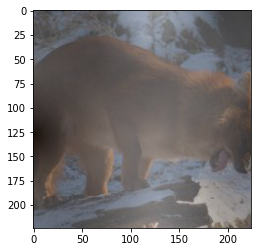

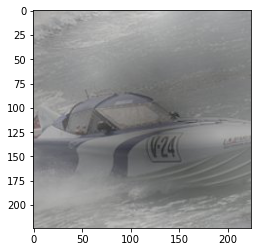

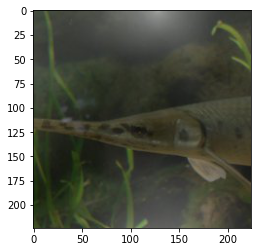

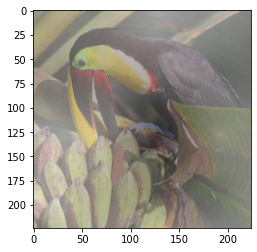

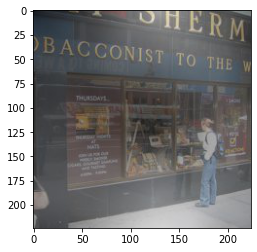

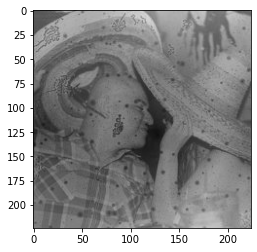

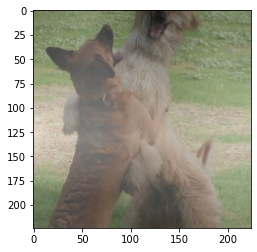

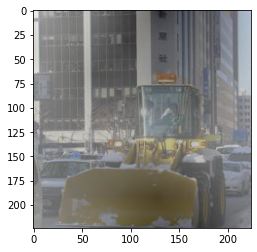

In [51]:
step=0
for images, targets in fog_loader:
    plt.imshow((images[0]).permute(1, 2, 0))
    plt.show()

In [18]:
def get_imagenet(imagebase, batch_size=128, sample_size = 128):
    # this is the imageNet validation data
    imagenet_val = datasets.ImageNet(imagebase+'imagenetc/', split='val', transform=transforms.Compose([
            transforms.Resize([224, 224]),
            transforms.CenterCrop((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
                                   target_transform=None)#, download=False)
    
    # TODO: subsample some size of ImageNet training data as source
        # Doesn't need this step
#     print("DEBUGGING: imagenet_val size is:", len(imagenet_val))
    
    random_indices = random.sample(range(0, len(imagenet_val)), int(len(imagenet_val)*0.02))
#     print("DEBUGGING: random indices are:", len(random_indices))
    imagenet_val_subset = data.Subset(imagenet_val, random_indices)
    val_loader = torch.utils.data.DataLoader(imagenet_val_subset,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=48)
    ref_dataloaders = { 'val': val_loader,
                       'test': val_loader}
    ref_dataset_sizes ={'val': int(len(val_loader.dataset)),
                        'test': int(len(val_loader.dataset))}
    
    return ref_dataloaders

# Adaptation helper functions

In [41]:
def online_evaluate(corrupt_loaders, corrutpion, severity, lr):
    start = time.time()
    resnet50 = models.resnet50(pretrained=True)
    resnet50 = tent.configure_model(resnet50)
    params, param_names = tent.collect_params(resnet50)
    optimizer = SGD(params, lr=lr)
    tented_resnet50 = tent.Tent(resnet50, optimizer).to(device)

    num_correct, num_samples = 0., 0.
    
    trainloader = corrupt_loaders[corrutpion][severity-1]['train']

    for images, targets in trainloader:
        logits = tented_resnet50(images.to(device))
        predictions = logits.argmax(dim=1)
        num_correct += (predictions.detach().cpu() == targets).float().sum()
        num_samples += len(targets)

    adapt_time = time.time() - start
    accuracy = num_correct / num_samples
    print(f"Acc =: {num_correct:#5.0f}/{num_samples:#5.0f} ({100 * accuracy: .2f} %), \
            Error =: {100 * (1 - accuracy): .2f} %")
    print(f"Adaptation time for one epoch on {num_samples} images takes {adapt_time}s")
    return tented_resnet50, accuracy, adapt_time


In [13]:
def offline_validate(model, corrupt_loaders, corruption, severity, baseline=False, clean_data=False, bn_adapt=False):
    if baseline:
        if not bn_adapt:
            model.eval()
        else:
            model.train() # TODO: this is a very sloppy way of doing it, change it
    else:
        if not bn_adapt: # If we don't adapt the BN statistics at validation time, set to eval mode.
            model.model.eval() 
        model.offline_validation()
        
    if clean_data:
        valloader = corrupt_loaders['clean']
    else:
        valloader = corrupt_loaders[corruption][severity-1]['val']
    
    num_correct, num_samples = 0., 0.

#     with model.no_grad():
    for images, targets in valloader:
        logits = model(images.to(device))
        predictions = logits.argmax(dim=1)
        num_correct += (predictions.detach().cpu() == targets).float().sum()
        num_samples += len(targets)

    accuracy = num_correct / num_samples
    print(f"Validation Acc =: {num_correct:#5.0f}/{num_samples:#5.0f} ({100 * accuracy: .2f} %), \
            Validation Error =: {100 * (1 - accuracy): .2f} %")
    
    return accuracy

In [14]:
imnc_corruption[7]

'snow'

# Replicating TENT

In [15]:
lr = 0.00025
bs = 64

TENT_replicate = np.zeros((len(imnc_corruption), 5))

# ONLINE adaptation adaptation on the "training set"

for corr in imnc_corruption:
    online_acc_sum = 0
#     validate_acc_sum = 0

    for severity in range(1,6):
        
        sev_ind = severity - 1
        corr_ind = imnc_corruption.index(corr)
        
        print(f"Corruption: {corr}, Severity: {severity}")
        
        # online adaptation:
        start = time.time()
        adapted_model, accuracy, _ = online_evaluate(imc_loaders, corr, severity, lr)
        adapt_time = time.time() - start
        online_acc_sum += accuracy
        
        TENT_replicate[corr_ind][sev_ind] = accuracy
        print('------------------------------------------------------------------------')
        
    
    print(f"Averag online accuracy for {corr}: {100 * (online_acc_sum / 5): .2f} %, \
            Averag online error for {corr}: {100 * (1 - online_acc_sum / 5): .2f} % ")
    print("======================================================================================")
    with open('TENT_replicate.npy', 'wb') as f:
        np.save(f, TENT_replicate)
    


Corruption: gaussian_noise, Severity: 1
Acc =: 32390./49000. ( 66.10 %),             Error =:  33.90 %
Adaptation time for one epoch on 49000.0 images takes 140.34958720207214s
------------------------------------------------------------------------
Corruption: gaussian_noise, Severity: 2
Acc =: 28864./49000. ( 58.91 %),             Error =:  41.09 %
Adaptation time for one epoch on 49000.0 images takes 133.40378975868225s
------------------------------------------------------------------------
Corruption: gaussian_noise, Severity: 3
Acc =: 23607./49000. ( 48.18 %),             Error =:  51.82 %
Adaptation time for one epoch on 49000.0 images takes 133.6061234474182s
------------------------------------------------------------------------
Corruption: gaussian_noise, Severity: 4
Acc =: 17085./49000. ( 34.87 %),             Error =:  65.13 %
Adaptation time for one epoch on 49000.0 images takes 133.91473865509033s
------------------------------------------------------------------------
C

Acc =: 15058./49000. ( 30.73 %),             Error =:  69.27 %
Adaptation time for one epoch on 49000.0 images takes 133.90384197235107s
------------------------------------------------------------------------
Averag online accuracy for motion_blur:  51.25 %,             Averag online error for motion_blur:  48.75 % 
Corruption: zoom_blur, Severity: 1
Acc =: 30951./49000. ( 63.17 %),             Error =:  36.83 %
Adaptation time for one epoch on 49000.0 images takes 133.70321393013s
------------------------------------------------------------------------
Corruption: zoom_blur, Severity: 2
Acc =: 28033./49000. ( 57.21 %),             Error =:  42.79 %
Adaptation time for one epoch on 49000.0 images takes 134.04043626785278s
------------------------------------------------------------------------
Corruption: zoom_blur, Severity: 3
Acc =: 26003./49000. ( 53.07 %),             Error =:  46.93 %
Adaptation time for one epoch on 49000.0 images takes 133.74341487884521s
----------------------

Acc =: 10706./49000. ( 21.85 %),             Error =:  78.15 %
Adaptation time for one epoch on 49000.0 images takes 134.05504250526428s
------------------------------------------------------------------------
Averag online accuracy for contrast:  55.32 %,             Averag online error for contrast:  44.68 % 
Corruption: elastic_transform, Severity: 1
Acc =: 34001./49000. ( 69.39 %),             Error =:  30.61 %
Adaptation time for one epoch on 49000.0 images takes 134.11020731925964s
------------------------------------------------------------------------
Corruption: elastic_transform, Severity: 2
Acc =: 26174./49000. ( 53.42 %),             Error =:  46.58 %
Adaptation time for one epoch on 49000.0 images takes 133.9103262424469s
------------------------------------------------------------------------
Corruption: elastic_transform, Severity: 3
Acc =: 32979./49000. ( 67.30 %),             Error =:  32.70 %
Adaptation time for one epoch on 49000.0 images takes 134.49106454849243s
--

In [11]:
with open('TENT_replicate.npy', 'rb') as f:
    TENT_replicate = np.load(f)

In [25]:
1 - TENT_replicate.mean(axis=1)

array([0.54625715, 0.56365305, 0.57301224, 0.58500001, 0.59089794,
       0.48748572, 0.47263265, 0.51882857, 0.52266122, 0.37917143,
       0.2918    , 0.44675919, 0.40014286, 0.36765714, 0.39946123])

In [14]:
1 - TENT_replicate.mean()

0.47636136035124466

In [22]:
TENT_replicate[:, 0]

array([0.6610204 , 0.64744896, 0.60748982, 0.63834691, 0.65016329,
       0.6970408 , 0.63165307, 0.62171429, 0.6462245 , 0.68840814,
       0.74346942, 0.71218365, 0.69389796, 0.71289796, 0.69553059])

In [16]:
from data import ImageNetCDataset

In [17]:
data_transforms = {
        'train': transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    }
imnc_train = ImageNetCDataset(imagebase+'imagenetc/' + 'snow' + '/' + str(1), data_transforms['train'])
imnc_test = ImageNetCDataset(imagebase+'imagenetc/' + 'snow' + '/' + str(1), data_transforms['test'])

In [18]:
dataloaders, dataset_sizes = split_dataset(imnc_train, imnc_test, train_size = 50000)

In [19]:
dataloaders['train']

In [20]:
start = time.time()
resnet50 = models.resnet50(pretrained=True)
resnet50 = tent.configure_model(resnet50)
params, param_names = tent.collect_params(resnet50)
optimizer = SGD(params, lr=0.00025)
tented_resnet50 = tent.Tent(resnet50, optimizer).to(device)

num_correct, num_samples = 0., 0.

trainloader = dataloaders['train']

for images, targets in trainloader:
    logits = tented_resnet50(images.to(device))
    predictions = logits.argmax(dim=1)
    num_correct += (predictions.detach().cpu() == targets).float().sum()
    num_samples += len(targets)

adapt_time = time.time() - start
accuracy = num_correct / num_samples
print(f"Acc =: {num_correct:#5.0f}/{num_samples:#5.0f} ({100 * accuracy: .2f} %), \
        Error =: {100 * (1 - accuracy): .2f} %")
print(f"Adaptation time for one epoch on {num_samples} images takes {adapt_time}s")

Acc =: 30392./49000. ( 62.02 %),         Error =:  37.98 %
Adaptation time for one epoch on 49000.0 images takes 134.7075159549713s
